# Predicting Landscape images from the Intel Image Classification Dataset

## Google colab Setup

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rayba2","key":"59da0e6b0aa855e7d239e93e3568700d"}'}

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d puneet6060/intel-image-classification

 99% 344M/346M [00:15<00:00, 25.0MB/s]
100% 346M/346M [00:15<00:00, 22.8MB/s]


In [ ]:
!mkdir intel

In [ ]:
!unzip intel-image-classification.zip -d intel

In [ ]:
train_dataset_path = '/content/intel/seg_train/seg_train'
validation_dataset_path = '/content/intel/seg_test/seg_test'

IMG_WIDTH = 150
IMG_HEIGHT = 150
BATCH_SIZE = 128

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_image_generator = ImageDataGenerator(rescale=1.0/255)


train_data_gen = train_image_generator.flow_from_directory(train_dataset_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 14034 images belonging to 6 classes.


In [ ]:
test_image_generator = ImageDataGenerator(rescale=1.0/255)

test_data_gen = test_image_generator.flow_from_directory(validation_dataset_path,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 3000 images belonging to 6 classes.


In [ ]:
sample_batch = next(train_data_gen)

sample_batch[0].shape

(128, 150, 150, 3)

In [ ]:
labels_list = list(train_data_gen.class_indices.keys())
print(labels_list)

labels_dict = {v: k for k, v in train_data_gen.class_indices.items()}
print(labels_dict)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
{0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}


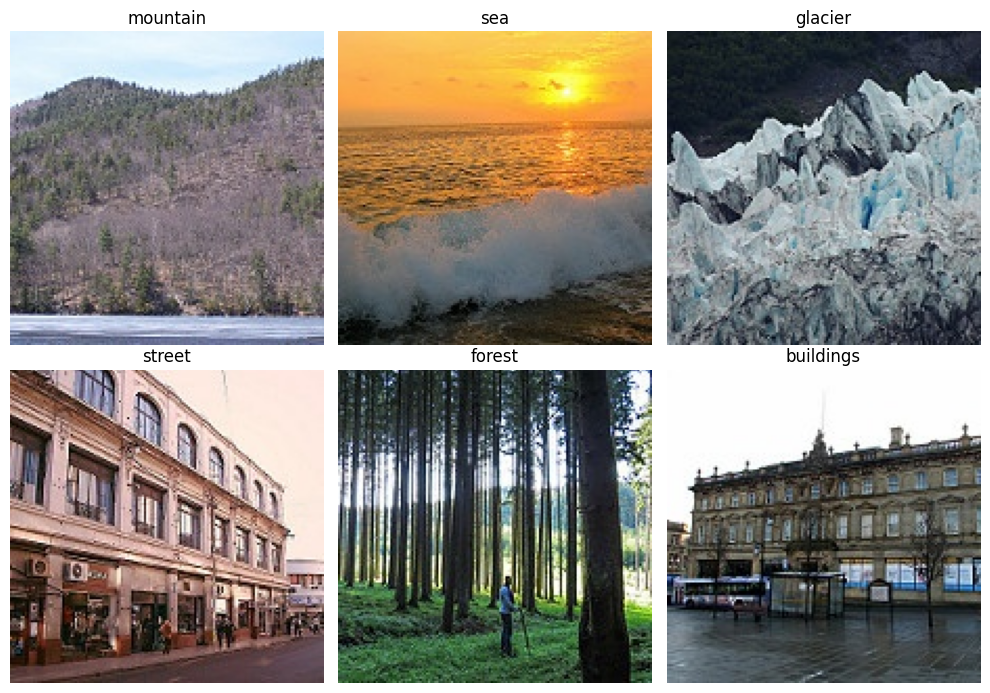

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

fig, axes = plt.subplots(2, 3, figsize=(10, 7))  # Create a 2x3 subplot grid
row_index = 0
col_index = 0

for folder in os.listdir(train_dataset_path):
    folder_path = os.path.join(train_dataset_path, folder)
    if os.path.isdir(folder_path):
        files = os.listdir(folder_path)
        if len(files) > 0:
            first_file = files[0]
            img_path = os.path.join(folder_path, first_file)
            img = Image.open(img_path)
            ax = axes[row_index][col_index]
            ax.imshow(img)
            ax.set_title(folder)  # Title is folder name
            ax.axis('off')

            col_index += 1
            if col_index == 3:
                row_index += 1
                col_index = 0

plt.tight_layout()
plt.show()

In [ ]:
from tqdm import tqdm
import cv2
import numpy as np

class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
IMAGE_SIZE = (150, 150)

def load_data():
    """
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images to evaluate how accurately the network learned to classify images.
    """

    datasets = ['/content/intel/seg_train/seg_train', '/content/intel/seg_test/seg_test']
    output = []

    # Iterate through training and test sets
    for dataset in datasets:

        images = []
        labels = []

        print("Loading {}".format(dataset))

        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]

            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):

                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)

                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE)

                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)

        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')

        output.append((images, labels))

    return output

(train_images, train_labels), (test_images, test_labels) = load_data()

Loading /content/intel/seg_train/seg_train


100%|██████████| 2191/2191 [00:01<00:00, 1926.28it/s]


Loading /content/intel/seg_test/seg_test


100%|██████████| 437/437 [00:00<00:00, 1933.51it/s]


In [ ]:
train_images.shape, test_images.shape

((14034, 150, 150, 3), (3000, 150, 150, 3))

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout

model = tf.keras.models.Sequential([

    Conv2D(16, (3, 3), padding='same', activation='relu',
                  input_shape=sample_batch[0].shape[1:]),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Dropout(0.25),

    Conv2D(64, (3, 3), padding='same', activation='relu'),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Dropout(0.25),

    Flatten(),

    Dense(512, activation='relu'),

    Dropout(0.25),

    Dense(256, activation='relu'),
    Dense(len(class_names), activation='softmax')

])

In [ ]:
model.compile(optimizer='adam',
                   loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                   metrics=['accuracy'])

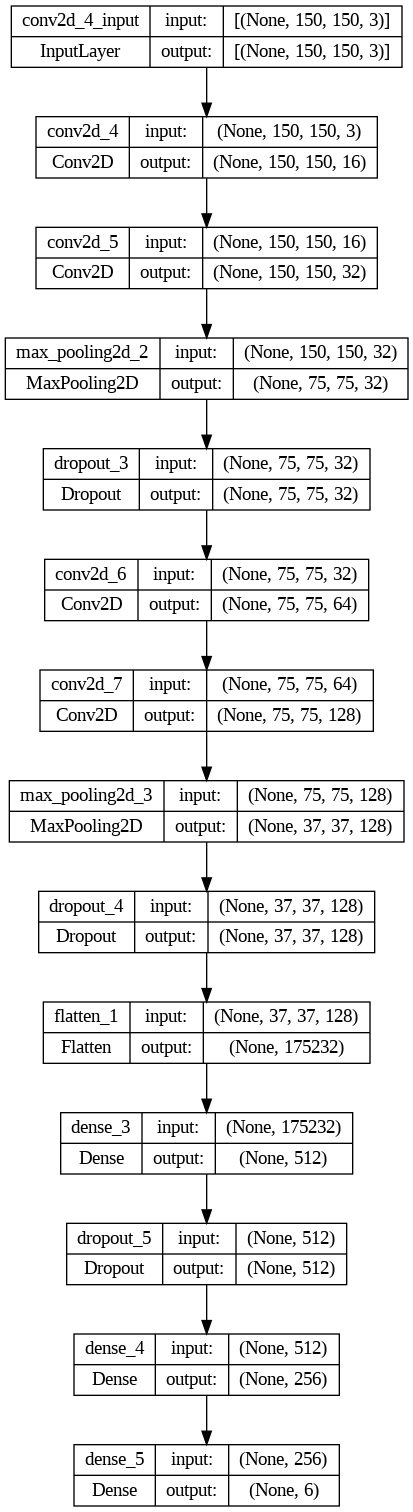

In [ ]:
import keras
keras.utils.plot_model(model, 'model_image_classification_shapes.png', show_shapes=True)

In [ ]:
training_hist = model.fit(train_data_gen,
                               epochs=5,
                               steps_per_epoch=len(train_images) // BATCH_SIZE,
                               validation_data=test_data_gen,
                               validation_steps=len(test_images) // BATCH_SIZE)

Epoch 1/5
109/109 [==============================] - 37s 323ms/step - loss: 1.3876 - accuracy: 0.5032 - val_loss: 0.8974 - val_accuracy: 0.6495
Epoch 2/5
109/109 [==============================] - 36s 327ms/step - loss: 0.8153 - accuracy: 0.6865 - val_loss: 0.6952 - val_accuracy: 0.7429
Epoch 3/5
109/109 [==============================] - 36s 329ms/step - loss: 0.6562 - accuracy: 0.7574 - val_loss: 0.6594 - val_accuracy: 0.7677
Epoch 4/5
109/109 [==============================] - 35s 316ms/step - loss: 0.5455 - accuracy: 0.8004 - val_loss: 0.6147 - val_accuracy: 0.7880
Epoch 5/5
109/109 [==============================] - 36s 329ms/step - loss: 0.4577 - accuracy: 0.8363 - val_loss: 0.5396 - val_accuracy: 0.8067


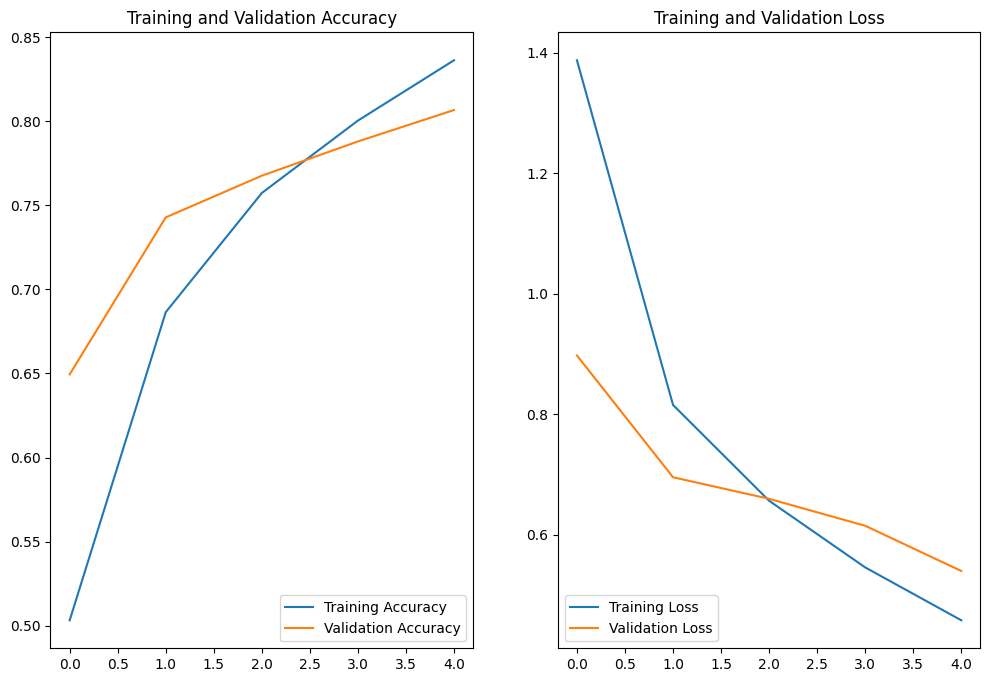

In [ ]:
acc = training_hist.history['accuracy']
val_acc = training_hist.history['val_accuracy']

loss = training_hist.history['loss']
val_loss = training_hist.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')

plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')

plt.legend(loc='lower left')

plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.save("trained_model.h5")

In [ ]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(validation_dataset_path,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')

Found 3000 images belonging to 6 classes.


In [ ]:
predictions = model.predict(test_generator)

24/24 [==============================] - 5s 190ms/step


1/1 [==============================] - 0s 18ms/step


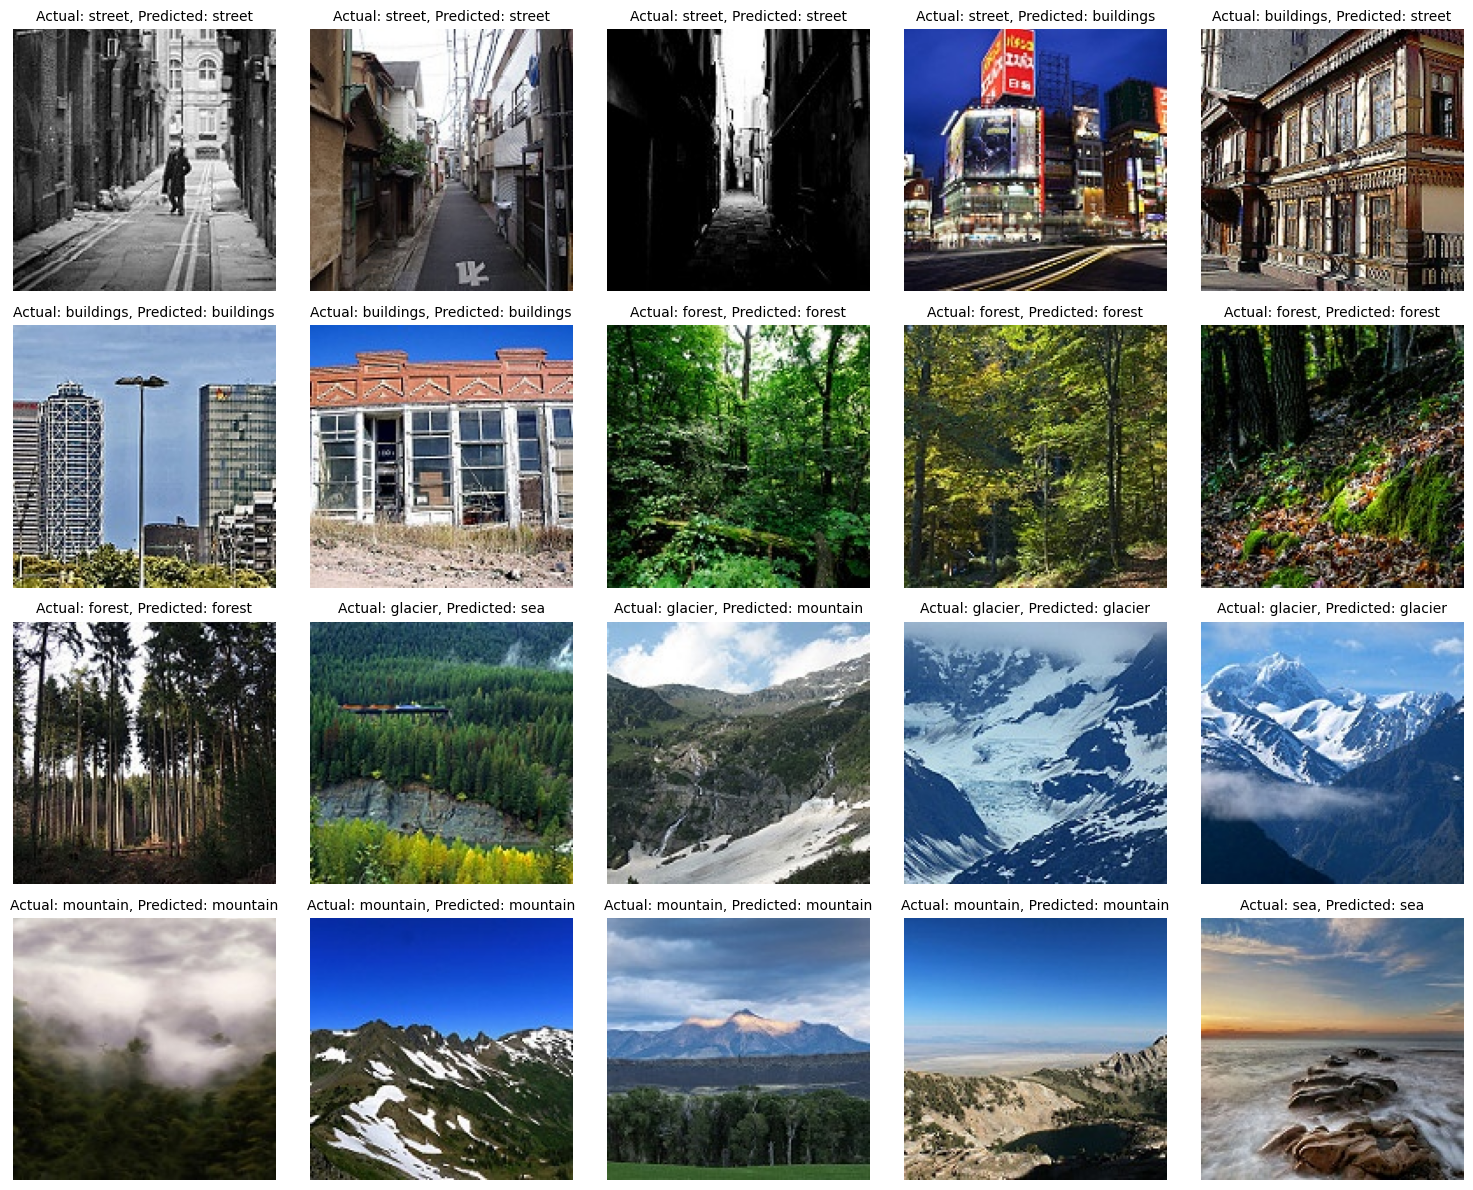

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

num_tests = 20
num_rows = 4
num_cols = 5
total_images = num_rows * num_cols

fig, ax = plt.subplots(num_rows, num_cols, figsize=(15, 12))

index = 0
for _ in range(num_tests):
    batch_images, batch_labels = next(test_generator)
    num_images_in_batch = batch_images.shape[0]

    random_image_index = random.randint(0, num_images_in_batch - 1)
    img = batch_images[random_image_index]
    actual_label_index = np.argmax(batch_labels[random_image_index])
    actual_label = labels_dict[actual_label_index]

    predicted_label_index = np.argmax(model.predict(np.expand_dims(img, axis=0)))
    predicted_label = labels_dict[predicted_label_index]

    ax[index // num_cols, index % num_cols].imshow(img)
    ax[index // num_cols, index % num_cols].set_title(f"Actual: {actual_label}, Predicted: {predicted_label}", fontsize=10)
    ax[index // num_cols, index % num_cols].axis('off')

    index += 1

    if index >= total_images:
        break

for i in range(index, total_images):
    ax[i // num_cols, i % num_cols].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, batch_size=BATCH_SIZE)
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

24/24 [==============================] - 3s 141ms/step - loss: 0.5379 - accuracy: 0.8077
Test Loss:     0.5379340052604675
Test Accuracy: 0.8076666593551636
